## Preparing for pre-processing

### Installing and importing required modules

In [ ]:
%pip install nltk pymystem3 matplotlib

In [2]:
import sqlite3
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

### Connecting to the database and getting posts

In [4]:
conn = sqlite3.connect('/home/sh1ron/HSE/MLOps_pipeline/database.db')
cursor = conn.cursor()

cursor.execute("SELECT * FROM posts")
posts = cursor.fetchall()

cursor.execute("SELECT * FROM reactions")
reactions = cursor.fetchall()

conn.close()

## Data preprocessing

In [5]:
stop_words = set(stopwords.words('russian'))

m = Mystem()

lemmatized_posts = []
for post in posts:
   text = re.sub('[^а-яА-ЯёЁ\s]', '', post[2])
   text = re.sub('\s+', ' ', text)
   text = text.lower()
   
   tokens = word_tokenize(text, language='russian')
   lemmatized_tokens = [m.lemmatize(word)[0] if len(m.lemmatize(word)) > 0 else word for word in tokens if word not in stop_words]
   lemmatized_posts.append(lemmatized_tokens)

## Post analysis

### Finding the most popular words

In [6]:
flat_list = [item for sublist in lemmatized_posts for item in sublist]

word_counts = Counter(flat_list)
top_words = word_counts.most_common(5)

print(top_words)

[('москва', 3518), ('год', 2229), ('россия', 1987), ('который', 1425), ('рубль', 1345)]


### The ten most popular emotions

In [7]:
total_counts = defaultdict(int)

for reaction in reactions:
    emoji = reaction[2]
    if emoji is None:
        emoji = '❤'
    total_counts[emoji] += reaction[3]

sorted_emojis = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)
top_emojis = sorted_emojis[:10]

print(top_emojis)

[('👍', 9026409), ('👎', 8203921), ('😱', 2642514), ('❤', 2469077), ('🤔', 1215067), ('🗿', 1061651), ('😡', 502074), ('💘', 410270), ('🐳', 129172), ('🤡', 10259)]


### The ten most popular posts for each of the most popular reactions

In [ ]:
post_reactions = {}
for reaction in reactions:
    post_id = reaction[1]
    emoji = reaction[2]
    count = reaction[3]
    if post_id not in post_reactions:
        post_reactions[post_id] = {}
    post_reactions[post_id][emoji] = count

for reaction in top_emojis:
    emoji = reaction[0]
    reaction_count = reaction[1]
    
    filtered_posts = []
    for post in posts:
        if post[0] in post_reactions and emoji in post_reactions[post[0]]:
            filtered_posts.append((post, post_reactions[post[0]][emoji]))
    
    sorted_posts = sorted(filtered_posts, key=lambda x: x[1], reverse=True)

    top_10_posts = sorted_posts[:10]
    
    print(f"Top 10 posts for reaction '{emoji}':")
    for post, reaction_count in top_10_posts:
        print(f"Post ID: {post[0]}, Reaction Count: {reaction_count}")

### Data visualization

#### Date grouping

In [9]:
dates = []
for post in posts:
    date_str = post[4]
    date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') 
    dates.append(date)

#### Plot function

In [10]:
def plot_activity(counts, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlabel == 'Month':
        plt.xticks(rotation = 90)
    plt.show()

#### Activity graph by month

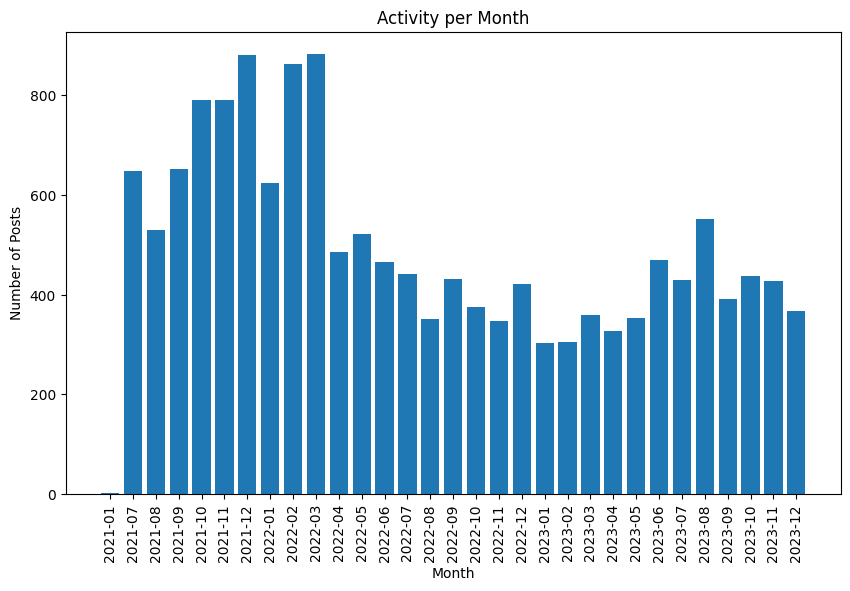

In [11]:
month_year_counts = defaultdict(int)
for date in dates:
    month_year_str = f"{date.year}-{date.month:02}"
    month_year_counts[month_year_str] += 1
plot_activity(month_year_counts, 'Activity per Month', 'Month', 'Number of Posts')

#### Activity graph by week

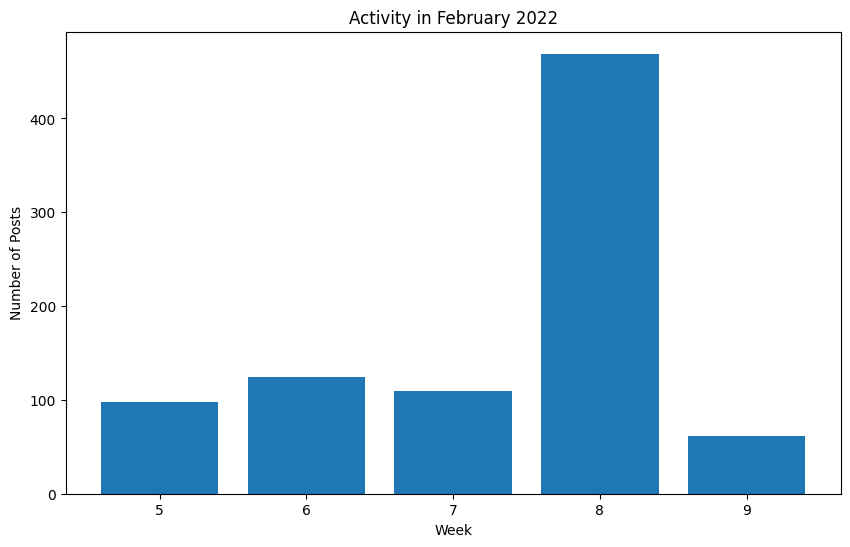

In [12]:
week_counts = defaultdict(int)
for date in dates:
    if date.year == 2022 and date.month == 2:
        week_counts[date.isocalendar()[1]] += 1
plot_activity(week_counts, 'Activity in February 2022', 'Week', 'Number of Posts')

#### Activity graph by day

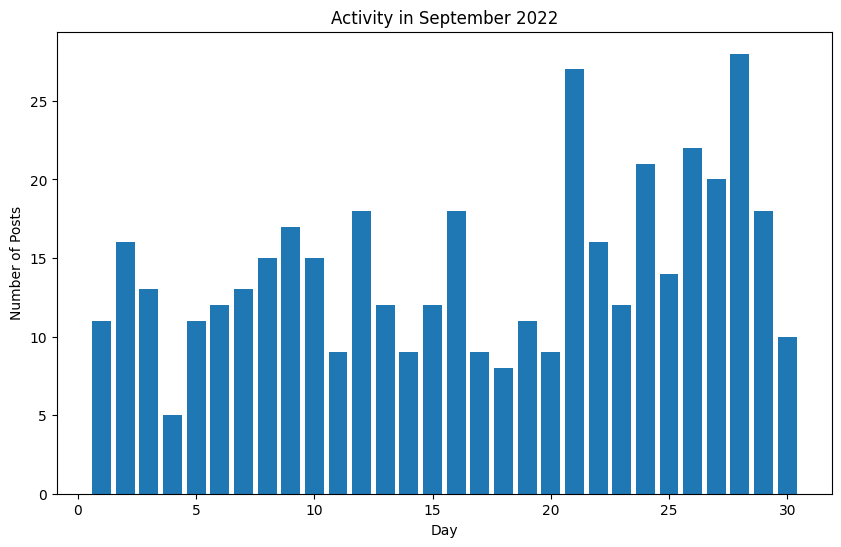

In [13]:
day_counts = defaultdict(int)
for date in dates:
    if date.year == 2022 and date.month == 9:
        day_counts[date.day] += 1
plot_activity(day_counts, 'Activity in September 2022', 'Day', 'Number of Posts')